In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import json
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt

In [2]:
# new file from joe on 11/5/24
dat = pd.read_csv('../data/grandmas_dead_filtered_cooccurrence.csv')

In [3]:
# make graph and do clustering
G = nx.Graph()
# Add edges with weights
for i, row in dat.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Cooccurrence_Count'])

In [4]:
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

Number of nodes: 99727
Number of edges: 471638


In [5]:
# Filter out non-influential nodes
# You can adjust the threshold based on your needs
degree_centrality = nx.degree_centrality(G)
# betweenness_centrality = nx.betweenness_centrality(G, weight='weight')

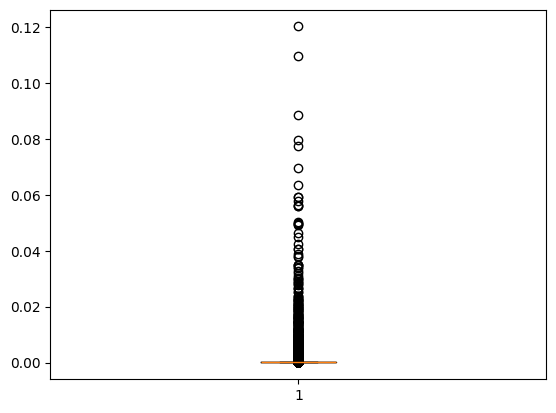

Mean Degree Centrality: 9.4845696495049e-05
Median Degree Centrality: 2.005495056454686e-05
Standard Deviation of Degree Centrality: 0.0012397096630870786
Max Degree Centrality: 0.12025951106030525
Min Degree Centrality: 1.002747528227343e-05
Inter-quartile range: 2.005495056454686e-05
75th percentile: 4.010990112909372e-05
25th percentile: 2.005495056454686e-05


In [6]:
# Analyze the distribution of betweenness centrality
centrality_values = list(degree_centrality.values())
# box plot
plt.boxplot(centrality_values)
plt.show()

# Calculate descriptive statistics
mean_centrality = np.mean(centrality_values)
median_centrality = np.median(centrality_values)
std_centrality = np.std(centrality_values)

print(f'Mean Degree Centrality: {mean_centrality}')
print(f'Median Degree Centrality: {median_centrality}')
print(f'Standard Deviation of Degree Centrality: {std_centrality}')
print(f'Max Degree Centrality: {max(centrality_values)}')
print(f'Min Degree Centrality: {min(centrality_values)}')
print(f"Inter-quartile range: {np.percentile(centrality_values, 75) - np.percentile(centrality_values, 25)}")
print(f"75th percentile: {np.percentile(centrality_values, 75)}"
        f"\n25th percentile: {np.percentile(centrality_values, 25)}")

---
### Graph filtering

1. filter edges by weight
2. remove isolated nodes
3. apply minimum degree threshold

In [7]:
# Check edge weights distribution
weights = [d['weight'] for (u,v,d) in G.edges(data=True)]
print("Total number of edges:", len(weights))
print("Min weight:", min(weights))
print("Max weight:", max(weights))
print("Sample of first 5 weights:", weights[:5])

# Get a frequency count of weights
from collections import Counter
weight_counts = Counter(weights)
print("\nWeight distribution:")
for weight, count in sorted(weight_counts.items())[:10]:  # Show first 10 weights
    print(f"Weight {weight}: {count} edges")

Total number of edges: 471638
Min weight: 1
Max weight: 1930
Sample of first 5 weights: [376, 387, 384, 1, 1]

Weight distribution:
Weight 1: 359494 edges
Weight 2: 49888 edges
Weight 3: 17963 edges
Weight 4: 10442 edges
Weight 5: 6317 edges
Weight 6: 3810 edges
Weight 7: 2944 edges
Weight 8: 2295 edges
Weight 9: 1568 edges
Weight 10: 1476 edges


In [8]:
# 1. Filter edges by weight
min_weight = np.percentile([d['weight'] for (u,v,d) in G.edges(data=True)], 25)  # bottom 25%
G_filtered = G.copy()
# More explicit filtering approach
edges_to_remove = []
for u, v, d in G.edges(data=True):
    if 'weight' in d:  # Check if weight attribute exists
        if d['weight'] <= min_weight:  # or whatever threshold you want
            edges_to_remove.append((u,v))
    else:
        print(f"Edge {u}-{v} has no weight attribute!")

print(f"Found {len(edges_to_remove)} edges to remove")
G_filtered.remove_edges_from(edges_to_remove)

Found 359494 edges to remove


In [9]:
# Remove any isolated nodes after edge removal
isolated_nodes = list(nx.isolates(G_filtered))
G_filtered.remove_nodes_from(isolated_nodes)

In [10]:
print("\nFiltered graph:")
print(f"Nodes: {G_filtered.number_of_nodes()}")
print(f"Edges: {G_filtered.number_of_edges()}")
print(f"Removed {len(isolated_nodes)} isolated nodes")



Filtered graph:
Nodes: 27505
Edges: 112144
Removed 72222 isolated nodes


In [11]:
avg_degree = sum(dict(G_filtered.degree()).values()) / G_filtered.number_of_nodes()
print(f"\nAverage degree: {avg_degree:.2f}")

# Look at the largest connected component
largest_cc = max(nx.connected_components(G_filtered), key=len)
print(f"Largest connected component has {len(largest_cc)} nodes")


Average degree: 8.15
Largest connected component has 27502 nodes


---
### Level 2 filtering to get CORE nodes

3 options: 90th percentile by degree, k-core, and pagerank

In [17]:
# 1. Using edge weights and degree together
# Calculate weighted degree for each node
# weighted_degrees = dict()
# for node in G_filtered.nodes():
#     weighted_degree = sum(d['weight'] for u, v, d in G_filtered.edges(data=True) if u == node or v == node)
#     weighted_degrees[node] = weighted_degree

# # Get 90th percentile of weighted degrees
# threshold = np.percentile(list(weighted_degrees.values()), 80)
# core_nodes = [node for node, w_degree in weighted_degrees.items() if w_degree >= threshold]

# # Create subgraph of core nodes
# G_core = G_filtered.subgraph(core_nodes).copy()

# print("\nCore graph (top 20% by weighted degree):")
# print(f"Nodes: {G_core.number_of_nodes()}")
# print(f"Edges: {G_core.number_of_edges()}")


Core graph (top 20% by weighted degree):
Nodes: 5595
Edges: 61947


In [18]:
# print("Core graph analysis (top 20% by weighted degree):")
# # Connectivity
# print(f"Number of connected components: {nx.number_connected_components(G_core)}")

# # Edge weight distribution
# weights = [d['weight'] for (u,v,d) in G_core.edges(data=True)]
# print(f"Min edge weight: {min(weights)}")
# print(f"Max edge weight: {max(weights)}")
# print(f"Mean edge weight: {np.mean(weights):.2f}")

# # Node degree distribution
# degrees = [d for n, d in G_core.degree()]
# print(f"Mean degree: {np.mean(degrees):.2f}")
# print(f"Median degree: {np.median(degrees):.2f}")

# # Calculate PageRank scores for the weighted degree core graph
# pr_core = nx.pagerank(G_core, weight='weight')
# top_hashtags = sorted(pr_core.items(), key=lambda x: x[1], reverse=True)[:10]
# print("\nTop 10 hashtags by PageRank in weighted degree core:")
# for hashtag, score in top_hashtags:
#     print(f"{hashtag}: {score:.6f}")

# # Additional weighted degree specific metrics
# print(f"\nWeighted degree specific metrics:")
# # Get weighted degree distribution
# weighted_degrees = {node: sum(d['weight'] for u, v, d in G_core.edges(data=True) if u == node or v == node) 
#                    for node in G_core.nodes()}
# print(f"Min weighted degree: {min(weighted_degrees.values())}")
# print(f"Max weighted degree: {max(weighted_degrees.values())}")
# print(f"Mean weighted degree: {np.mean(list(weighted_degrees.values())):.2f}")

Core graph analysis (top 20% by weighted degree):
Number of connected components: 1
Min edge weight: 2
Max edge weight: 1930
Mean edge weight: 19.18
Mean degree: 22.14
Median degree: 8.00

Top 10 hashtags by PageRank in weighted degree core:
addiction: 0.022237
recovery: 0.019797
harmreduction: 0.016122
wedorecover: 0.014342
sober: 0.014045
sobriety: 0.013415
addy: 0.011993
high: 0.011803
g: 0.010494
o: 0.010171

Weighted degree specific metrics:
Min weighted degree: 6
Max weighted degree: 83947
Mean weighted degree: 424.66


#### K-core decomposition

In [12]:
# 2. Alternative: k-core decomposition
# This will find the most densely connected subset of nodes
k_core = nx.k_core(G_filtered, k=10)  
print("\nk-core graph (k=10):")
print(f"Nodes: {k_core.number_of_nodes()}")
print(f"Edges: {k_core.number_of_edges()}")


k-core graph (k=10):
Nodes: 2333
Edges: 46990


In [13]:
print("K-core graph analysis (k=10):")
# Connectivity
print(f"Number of connected components: {nx.number_connected_components(k_core)}")

# Edge weight distribution
weights = [d['weight'] for (u,v,d) in k_core.edges(data=True)]
print(f"Min edge weight: {min(weights)}")
print(f"Max edge weight: {max(weights)}")
print(f"Mean edge weight: {np.mean(weights):.2f}")

# Node degree distribution
degrees = [d for n, d in k_core.degree()]
print(f"Min degree: {min(degrees)}")
print(f"Mean degree: {np.mean(degrees):.2f}")
print(f"Median degree: {np.median(degrees):.2f}")

# Calculate PageRank scores for the k-core graph to identify important nodes
pr_kcore = nx.pagerank(k_core, weight='weight')
top_hashtags = sorted(pr_kcore.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 hashtags by PageRank in k-core:")
for hashtag, score in top_hashtags:
    print(f"{hashtag}: {score:.6f}")

# Additional k-core specific metrics
print(f"\nK-core specific metrics:")
# Core number distribution
core_numbers = nx.core_number(k_core)
print(f"Min core number: {min(core_numbers.values())}")
print(f"Max core number: {max(core_numbers.values())}")
print(f"Mean core number: {np.mean(list(core_numbers.values())):.2f}")

K-core graph analysis (k=10):
Number of connected components: 1
Min edge weight: 2
Max edge weight: 1930
Mean edge weight: 12.76
Min degree: 10
Mean degree: 40.28
Median degree: 17.00

Top 10 hashtags by PageRank in k-core:
addiction: 0.027352
recovery: 0.024995
harmreduction: 0.023309
wedorecover: 0.020104
sober: 0.016685
sobriety: 0.014635
addy: 0.011009
soberlife: 0.010592
harmreductionworks: 0.009564
harmreductionsaveslives: 0.008948

K-core specific metrics:
Min core number: 10
Max core number: 46
Mean core number: 20.92


In [15]:
# export graph:
nx.write_gexf(k_core, "../graphs/hashtag_network_k10_nothemes.gexf")

In [14]:
# Perform clustering with Clauset-Newman-Moore algorithm
communities = list(greedy_modularity_communities(k_core))

# Assign community labels to nodes
community_dict = {}
for i, community in enumerate(communities):
    for node in community:
        community_dict[node] = i

# Add community information to the nodes in the graph
nx.set_node_attributes(k_core, community_dict, 'community')

# Print out the communities
for i, community in enumerate(communities):
    print(f"Community {i + 1}: {sorted(community)}")

Community 1: ['12step', '12stepprogram', '12steps', '12stepsinrecovery', '3days', '710', '716buffalo', '8ball', 'aa', 'accountability', 'accountabro', 'activeaddiction', 'activeaddictionstories', 'activeaddictionthings', 'activeaddictiontorecovery', 'activeaddictionvssobriety', 'activeuse', 'actuallyautistic', 'acutepain', 'addict', 'addictcomedy', 'addicted', 'addictedseries', 'addictedtotiktok', 'addicthumor', 'addictinrecovery', 'addiction', 'addictionawareness', 'addictioncrew', 'addictionfree', 'addictionhelp', 'addictionhumor', 'addictionisadisease', 'addictionisamentalhealthproblem', 'addictionisnotachoice', 'addictionisntfun', 'addictionisnthowyourstoryhastoend', 'addictionisreal', 'addictionisrealrecoveryisbeautiful', 'addictionisrealthereishope', 'addictionisrealyall', 'addictionjourney', 'addictionmedicine', 'addictionmindset', 'addictionrecovery', 'addictionrecoverycoach', 'addictions', 'addictionskit', 'addictionstories', 'addictionstory', 'addictionsupport', 'addictionsur

#### K-core 10 vs 5

k=5:

More nodes/edges (as expected)  
Mean degree: 24.35  
Core numbers: min=5, max=46, mean=12.52  
Starting to see noise in top hashtags ('g', 'o', 'x')  


k=10:

Fewer nodes/edges  
Mean degree: 40.23  
Core numbers: min=10, max=46, mean=20.92  
Cleaner top hashtags (no single-letter noise)  

Positives:

Still maintains community structure   
Main thematic hashtags still at the top (addiction, recovery, harmreduction)  
Mean core number of 12.52 shows many nodes are still well-connected  
Single connected component = coherent network  

Tradeoffs:

More noise in top hashtags  
Lower mean degree (24.35 vs 40.23)  
Visualization will be more crowded  

#### PageRank Importance - will not consider

In [17]:
pr = nx.pagerank(G_filtered, weight='weight')
# Keep top 2000 nodes (or adjust number as needed)
top_nodes = sorted(pr.items(), key=lambda x: x[1], reverse=True)[:2000]
G_pagerank = G_filtered.subgraph([node for node, score in top_nodes]).copy()

print("\nPageRank-filtered graph (top 2000 nodes):")
print(f"Nodes: {G_pagerank.number_of_nodes()}")
print(f"Edges: {G_pagerank.number_of_edges()}")


PageRank-filtered graph (top 2000 nodes):
Nodes: 2000
Edges: 36995


In [18]:
print("PageRank graph analysis:")
# Connectivity
print(f"Number of connected components: {nx.number_connected_components(G_pagerank)}")

# Edge weight distribution
weights = [d['weight'] for (u,v,d) in G_pagerank.edges(data=True)]
print(f"Min edge weight: {min(weights)}")
print(f"Max edge weight: {max(weights)}")
print(f"Mean edge weight: {np.mean(weights):.2f}")

# Node degree distribution
degrees = [d for n, d in G_pagerank.degree()]
print(f"Mean degree: {np.mean(degrees):.2f}")
print(f"Median degree: {np.median(degrees):.2f}")

# Optional: Look at some top hashtags
pr_subset = {node: score for node, score in pr.items() if node in G_pagerank.nodes()}
top_hashtags = sorted(pr_subset.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 hashtags by PageRank:")
for hashtag, score in top_hashtags:
    print(f"{hashtag}: {score:.6f}")

PageRank graph analysis:
Number of connected components: 1
Min edge weight: 2
Max edge weight: 1825
Mean edge weight: 26.84
Mean degree: 36.99
Median degree: 16.00

Top 10 hashtags by PageRank:
addiction: 0.017710
recovery: 0.014172
harmreduction: 0.011970
wedorecover: 0.010917
sober: 0.009830
sobriety: 0.008844
cat: 0.008692
o: 0.008666
addy: 0.008647
g: 0.008272


#### Decision: K-Core filtering
1. Structural advantages:  

Highest mean degree (40.23)  
Guaranteed minimum connectivity (k=10)  
More edges but lower mean weight suggests better coverage of relationships  


2. Best thematic coherence:  

Top hashtags form the most coherent theme  
Less noise in top hashtags compared to other methods  
No single-letter or ambiguous hashtags in top 10  


3. Size and density balance:  

Middle ground in node count (2340)  
Highest edge count suggests better preserved relationships  
Core number distribution provides natural community structure  


4. Quality guarantees:  

K-core gives us mathematical guarantees about connectivity  
Other methods might include peripheral nodes just because they have a few high-weight edges 

---
# SEE `get_graph.py` for network analysis

## Add in themes from `get_themes.py` as community

In [15]:
# export k=10 to spreadsheet
k_nodes_list = list(k_core.nodes())

# Convert to DataFrame
k_nodes_df = pd.DataFrame(k_nodes_list, columns=['hashtag'])

# Write to CSV
k_nodes_df.to_csv('../data/kcore_10_nodes.csv', index=False)

In [26]:
# Load communities
communities = pd.read_csv("../data/hashtags_5core_with_themes.csv")

# For k=5 graph
def add_community_info(graph, communities_df):
    # Create community dictionary
    community_dict = communities_df.set_index('hashtag')['theme'].to_dict()
    
    # Add community as node attribute
    nx.set_node_attributes(graph, community_dict, 'community')
    
    # Print some statistics about communities in the graph
    graph_communities = [community_dict.get(node, 'misc') for node in graph.nodes()]
    community_counts = pd.Series(graph_communities).value_counts()
    
    print("Community distribution:")
    for comm, count in community_counts.items():
        print(f"{comm}: {count} nodes")

    # Print nodes with unknown communities
    # unknown_nodes = [node for node in graph.nodes() if community_dict.get(node, 'unknown') == 'unknown']
    # print(f"\nNumber of nodes with unknown community: {len(unknown_nodes)}")
    # if len(unknown_nodes) > 0:
    #     print("Nodes without community assignment:")
    #     print(unknown_nodes)
    return graph

In [27]:
# Add communities to k=5 graph
k5_with_communities = add_community_info(k_core, communities)

# Export k=5 graph for Gephi
nx.write_gexf(k5_with_communities, "../graphs/hashtag_network_k5.gexf")

Community distribution:
misc: 2299 nodes
awareness and advocacy: 646 nodes
platform: 377 nodes
emotions and feelings: 336 nodes
identity and community: 301 nodes
health conditions: 293 nodes
location: 278 nodes
commonly-misused substances: 211 nodes
occupation: 147 nodes
other substances: 120 nodes
humor: 110 nodes
consumption method: 104 nodes
substance effects: 70 nodes
alcohol: 66 nodes
cannabis: 63 nodes
tobacco_nicotine: 62 nodes
cognitive enhancement: 29 nodes
addiction and recovery: 6 nodes
publichealth: 1 nodes


In [28]:
# For k=10 graph
k10_core = nx.k_core(G_filtered, k=10)
k10_with_communities = add_community_info(k10_core, communities)
nx.write_gexf(k10_with_communities, "../graphs/hashtag_network_k10.gexf")

Community distribution:
misc: 853 nodes
awareness and advocacy: 319 nodes
platform: 180 nodes
emotions and feelings: 152 nodes
commonly-misused substances: 133 nodes
health conditions: 127 nodes
identity and community: 116 nodes
location: 95 nodes
occupation: 58 nodes
other substances: 53 nodes
consumption method: 50 nodes
humor: 46 nodes
cannabis: 46 nodes
substance effects: 42 nodes
alcohol: 27 nodes
tobacco_nicotine: 22 nodes
cognitive enhancement: 9 nodes
addiction and recovery: 4 nodes
publichealth: 1 nodes


In [29]:
# Print comparison of graphs
print("\nK=5 Graph:")
print(f"Nodes: {k5_with_communities.number_of_nodes()}")
print(f"Edges: {k5_with_communities.number_of_edges()}")

print("\nK=10 Graph:")
print(f"Nodes: {k10_with_communities.number_of_nodes()}")
print(f"Edges: {k10_with_communities.number_of_edges()}")


K=5 Graph:
Nodes: 5519
Edges: 67204

K=10 Graph:
Nodes: 2333
Edges: 46990


In [30]:
# get nodelist with PageRank scores
node_data = []
# Calculate PageRank
pagerank_scores = nx.pagerank(k5_with_communities, weight='weight')

for node in k5_with_communities.nodes():
    community = k5_with_communities.nodes[node].get('community')
    weighted_degree = sum(weight for _, _, weight in k5_with_communities.edges(node, data='weight', default=1))
    
    node_data.append({
        'Node': node,
        'Community': community,
        'Weighted_Degree': weighted_degree,
        'PageRank': pagerank_scores[node]
    })

# Create a DataFrame
node_data_df = pd.DataFrame(node_data)

# Sort by PageRank score (most influential to least)
node_data_df = node_data_df.sort_values('PageRank', ascending=False)

# Write to CSV
node_data_df.to_csv('../data/k5_nodes_ranked.csv', index=False, quoting=1)  # quoting=1 ensures all fields are quoted

# Print top 10 to verify
print("Top 10 most influential nodes:")
print(node_data_df.head(10))

Top 10 most influential nodes:
               Node                    Community  Weighted_Degree  PageRank
1783      addiction            health conditions            44359  0.028044
4115       recovery       awareness and advocacy            37958  0.023917
838   harmreduction       awareness and advocacy            34289  0.020862
296     wedorecover       awareness and advocacy            29762  0.018579
4133          sober       awareness and advocacy            24285  0.014719
3572       sobriety       awareness and advocacy            22021  0.013280
5047           addy        cognitive enhancement            81693  0.011287
4416              g  commonly-misused substances            71918  0.010594
3815              o                         misc            69927  0.010305
2779              x                         misc            70280  0.010164


---
### OLD

In [24]:
# add themes as nodes
communities = pd.read_csv("../data/themes_with_missing_long.csv")

In [25]:
# Create a dictionary mapping hashtags to themes
community_map = dict(zip(communities['hashtag'], communities['theme']))

In [26]:
# Assign communities to nodes
for node in H.nodes():
    if node in community_map:
        H.nodes[node]['community'] = community_map[node]
    else:
        # Handle nodes that are not in the DataFrame
        H.nodes[node]['community'] = "Unknown"

In [33]:
# export for gephi
nx.write_gexf(H, '../graphs/double_hits_filtered_upper75_with_theme.gexf')

In [13]:
# add themes as nodes
# communities = pd.read_csv("../data/themes_with_missing_long.csv")
communities = pd.read_csv("../data/double_hits_filtered_upper75_with_theme_node_list_manually_classified.csv")

In [14]:
# replace the value of community if the value of Joe's theme is not missing.
communities.loc[(communities['Community'] == 'Unknown') & (communities["Joe\'s Community Tag"].notnull()), 'Community'] = communities["Joe\'s Community Tag"]

In [16]:
# Create a dictionary mapping hashtags to themes
community_map = dict(zip(communities['Node'], communities['Community']))

In [17]:
# Assign communities to nodes
for node in H.nodes():
    if node in community_map:
        H.nodes[node]['community'] = community_map[node]
    else:
        # Handle nodes that are not in the DataFrame
        H.nodes[node]['community'] = "Unknown"

In [18]:
# export for gephi
nx.write_gexf(H, '../graphs/double_hits_filtered_upper75_with_theme_no_unknown.gexf')

In [19]:
edge_data = []
for source, target, data in H.edges(data=True):
    weight = data.get('weight', 1)  # Default to 1 if weight is not specified
    source_community = H.nodes[source].get('community', 'Unknown')
    target_community = H.nodes[target].get('community', 'Unknown')
    edge_data.append({
        'Source': source,
        'Target': target,
        'Weight': weight,
        'Source_Community': source_community,
        'Target_Community': target_community
    })

# Create a DataFrame
edge_data_df = pd.DataFrame(edge_data)
edge_data_df.to_csv('../graphs/double_hits_filtered_upper75_with_theme_edge_list_full.csv', index=False)

In [20]:
# get nodelist
node_data = []
for node in H.nodes():
    community = H.nodes[node].get('community', 'Unknown')
    weighted_degree = sum(weight for _, _, weight in H.edges(node, data='weight', default=1))
    
    node_data.append({
        'Node': node,
        'Community': community,
        'Weighted_Degree': weighted_degree
    })

# Create a DataFrame
node_data_df = pd.DataFrame(node_data)

# Write to CSV
node_data_df.to_csv('../graphs/double_hits_filtered_upper75_with_theme_node_list_full.csv', index=False, quoting=1)  # quoting=1 ensures all fields are quoted


In [21]:
# experiment with no misc/unknown
subgraph = H.subgraph([
    node for node in H.nodes() 
    if H.nodes[node].get('community') not in ["misc", "Unknown"]
]).copy()

In [22]:
nx.write_gexf(subgraph, "../graphs/double_hits_filtered_upper75_with_theme_nomisc.gexf")

In [14]:
# export to csv
# nodes
# nodes = pd.DataFrame(H.nodes(data=True), columns=['node', 'data'])
# nodes['community'] = nodes['data'].apply(lambda x: x['community'])
# nodes.drop(columns=['data'], inplace=True)
# nodes.to_csv('../data/double_hits_filtered_upper75_nodes.csv', index=False)

In [19]:
# read seed hashtags and clusters
# seed_hashtags = pd.read_csv("community-grouping_20240730(in).csv")

In [22]:
def label_hashtags_by_clusters(G, seed_hashtags):
    # Create a dictionary to store the cluster for each hashtag
    hashtag_clusters = {}

    # Iterate through each theme and its associated hashtags
    for theme in seed_hashtags.columns[1:]:
        seed_nodes = seed_hashtags['Node'][seed_hashtags[theme] == 'y'].tolist()
        for seed in seed_nodes:
            # Get the ego network up to 2 hops
            ego_network = nx.ego_graph(G, seed, radius=1, undirected=True)
            for node in ego_network.nodes:
                if node not in hashtag_clusters:
                    hashtag_clusters[node] = set()
                hashtag_clusters[node].add(theme)
    
    # Convert the dictionary to a DataFrame
    labeled_hashtags = pd.DataFrame(list(hashtag_clusters.items()), columns=['Hashtag', 'Themes'])
    labeled_hashtags['Themes'] = labeled_hashtags['Themes'].apply(lambda x: list(x))
    
    return labeled_hashtags

In [23]:
labeled_hashtags = label_hashtags_by_clusters(H, seed_hashtags)

# OLD
---
TRIPLE HITS

In [18]:
# redo with triple hits
dat = pd.read_csv('triple_hits_edges_no_dupes.csv')

In [19]:
G2 = nx.Graph()
# Add edges with weights
for i, row in dat.iterrows():
    G2.add_edge(row['source'], row['target'], weight=row['weight'])

degree_centrality2 = nx.degree_centrality(G2)

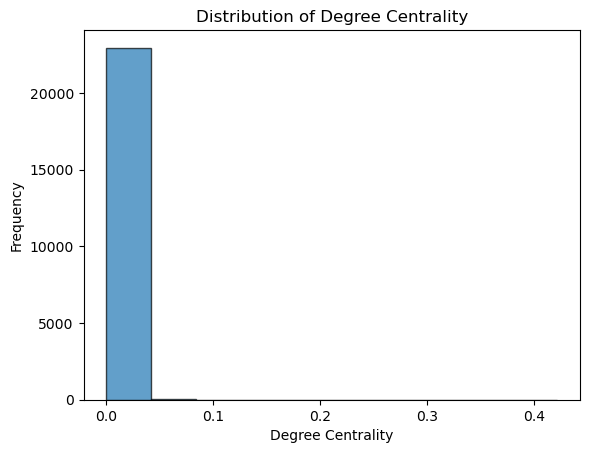

In [20]:
# plot degree centrality
centrality_values2 = list(degree_centrality2.values())
plt.hist(centrality_values2, edgecolor='k', alpha=0.7)
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Degree Centrality')
plt.show()


In [21]:
# descriptive statistics
mean_centrality2 = np.mean(centrality_values2)
median_centrality2 = np.median(centrality_values2)
std_centrality2 = np.std(centrality_values2)

print(f'Mean Degree Centrality: {mean_centrality2}')
print(f'Median Degree Centrality: {median_centrality2}')
print(f'Standard Deviation of Degree Centrality: {std_centrality2}')

# Set a threshold based on the distribution
# For example, use the mean or a multiple of the standard deviation
threshold2 = mean_centrality2 + std_centrality2  # Example threshold

Mean Degree Centrality: 0.0005783704455376405
Median Degree Centrality: 0.0001738299074355743
Standard Deviation of Degree Centrality: 0.0064888479505552325


In [22]:
filtered_nodes_D2 = [node for node, centrality in degree_centrality2.items() if centrality > threshold2]

H2 = G2.subgraph(filtered_nodes_D2)


In [23]:
# Perform clustering with Clauset-Newman-Moore algorithm
communities2 = list(greedy_modularity_communities(H2))

# Assign community labels to nodes
community_dict2 = {}
for i, community in enumerate(communities2):
    for node in community:
        community_dict2[node] = i

# Add community information to the nodes in the graph
nx.set_node_attributes(H2, community_dict2, 'community')

# Print out the communities
for i, community in enumerate(communities2):
    print(f"Community {i + 1}: {sorted(community)}")

Community 1: ['addictionhumor', 'addictionskit', 'bars', 'blackedout', 'blackout', 'coughsyrup', 'dr00g', 'dr00gtiktok', 'drank', 'drunk', 'drvgaddiction', 'drvgzx', 'hammered', 'hangover', 'harmreduction', 'hungover', 'lean', 'leantok', 'm0lly', 'molly', 'opiates', 'percs', 'pinger', 'pingertok', 'pingerzzzz', 'pingtok', 'recovery', 'relapsehappens', 'shitfaced', 'sober', 'soberlife', 'sobriety', 'syrup', 'tipsy', 'wasted', 'wedorecover', 'xan', 'xans', 'xantok']
Community 2: ['chronicpain', 'cleanandsober', 'detox', 'drugpolicy', 'drugrehab', 'endoverdose', 'fent', 'harmreductionsaveslives', 'harmreductiontips', 'harmreductionworks', 'heroin', 'methadoneclinic', 'na', 'naloxone', 'naloxonesaveslives', 'naltrexone', 'narcan', 'narcansaveslives', 'odaat', 'onedayatatime', 'opioidaddiction', 'opioidawareness', 'opioidcrisis', 'opioids', 'overdose', 'overdoseawareness', 'overdosecrisis', 'overdoseresponse', 'pain', 'pwud', 'safesupply', 'saynotodrugs', 'soberhouse', 'soberliving', 'sobri

In [24]:
nx.write_gexf(H2, 'triple_hits_filtered.gexf')

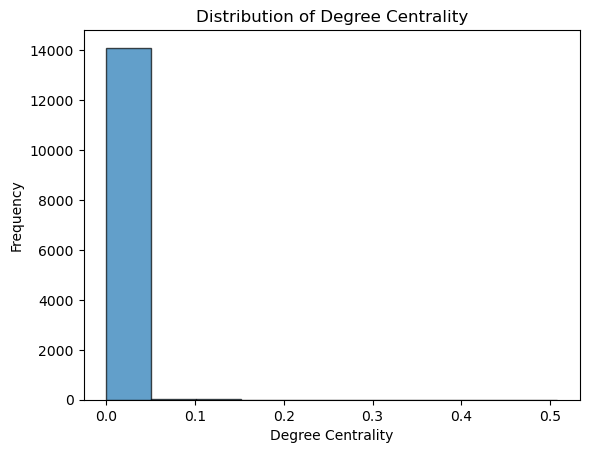

Mean Degree Centrality: 0.0011391684336007726
Median Degree Centrality: 0.0003532819896841659
Standard Deviation of Degree Centrality: 0.010455500072650259


In [25]:
# repeat for quadruple hits
dat = pd.read_csv('quadruple_hits_edges_no_dupes.csv')

G3 = nx.Graph()
# Add edges with weights
for i, row in dat.iterrows():
    G3.add_edge(row['source'], row['target'], weight=row['weight'])

degree_centrality3 = nx.degree_centrality(G3)

# plot degree centrality
centrality_values3 = list(degree_centrality3.values())
plt.hist(centrality_values3, edgecolor='k', alpha=0.7)
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Degree Centrality')
plt.show()


# descriptive statistics
mean_centrality3 = np.mean(centrality_values3)
median_centrality3 = np.median(centrality_values3)
std_centrality3 = np.std(centrality_values3)

print(f'Mean Degree Centrality: {mean_centrality3}')
print(f'Median Degree Centrality: {median_centrality3}')
print(f'Standard Deviation of Degree Centrality: {std_centrality3}')

# Set a threshold based on the distribution
threshold3 = mean_centrality3 + std_centrality3  


In [26]:
# filter
filtered_nodes_D3 = [node for node, centrality in degree_centrality3.items() if centrality > threshold3]

H3 = G3.subgraph(filtered_nodes_D3)


# Perform clustering with Clauset-Newman-Moore algorithm
communities3 = list(greedy_modularity_communities(H3))

# Assign community labels to nodes
community_dict3 = {}
for i, community in enumerate(communities3):
    for node in community:
        community_dict3[node] = i

# Add community information to the nodes in the graph
nx.set_node_attributes(H3, community_dict3, 'community')

# Print out the communities
for i, community in enumerate(communities3):
    print(f"Community {i + 1}: {sorted(community)}")

nx.write_gexf(H3, 'quadruple_hits_filtered.gexf')

Community 1: ['acid', 'addiction', 'addictionhumor', 'addictionskit', 'bars', 'blackedout', 'blackout', 'cigs', 'coughsyrup', 'dr00g', 'dr00gtiktok', 'drank', 'drunk', 'drvgaddiction', 'hammered', 'harmreductionsaveslives', 'high', 'hungover', 'lean', 'molly', 'na', 'percs', 'pinger', 'pingertok', 'pingerzzzz', 'pingtok', 'psychedelictok', 'recovery', 'shitfaced', 'sober', 'soberlife', 'sobriety', 'sobrietybirthday', 'stonertokfyp', 'tipsy', 'wasted', 'wedorecover', 'xan']
Community 2: ['chronicpain', 'cleanandsober', 'drugpolicy', 'drugrehab', 'endoverdose', 'fent', 'harmreductiontips', 'harmreductionworks', 'heroin', 'methadoneclinic', 'naloxone', 'naloxonesaveslives', 'naltrexone', 'narcan', 'narcansaveslives', 'odaat', 'onedayatatime', 'opiates', 'opioidaddiction', 'opioidawareness', 'opioidcrisis', 'opioids', 'overdose', 'overdoseawareness', 'overdosecrisis', 'pwud', 'relapsehappens', 'safesupply', 'soberhouse', 'soberliving', 'substanceabuse', 'substanceusedisorder']
Community 3: